# Estudio de las Ventas de una Ferretería
## NB4: Predicción de Ventas - Estudio de una Serie Temporal

>Autor: Diana Chacón Ocariz

### Contenido

1. [Introducción](#introduccion)
1. [Carga de librerías y datos](#carga)
1. [Funciones Generales](#funciones)
1. [Estudio Exploratorio de la Serie Temporal](#estudio)
    1. [Descomposición de la Serie](#estudio-descomposicion)
    1. [Estudio Estacionalidad](#estudio-estacionalidad)
    1. [Estudio Autocorrelación](#estudio-autocorrelacion)    
    1. [Conclusión](#estudio-conclusion)
1. [Transformación de la Serie Temporal](#transformacion-ts)
    1. [Tranformación logaritmica](#transformacion)
    1. [Verificación Estacionalidad](#verificacion-estacionalidad)  
1. [Modelado](#modelado)
    1. [Partición del dataset](#particion-ds)
1. [Glosario](#glosario)

## 1. Introducción<a name="introduccion"></a>

A partir de los datos de las ventas del 01-01-2020 al 28-02-2022 de una pequeña ferretería, buscamos predecir las ventas para los próximos 15 días a 1 mes.

Esto permitirá mejorar los procesos de compras, previsiones y la toma de decisiones en general. 

Los datos ya han sido recolectados, limpiados y transformados.

Se trata del estudio de una serie temporal: Veremos si se trata de una serie estacionaria o no. En caso de no serlo, haremos las transformaciones necesarias, elegiremos el modelo más apropiado, lo probaremos y ajustaremos.


## 2. Carga de librerías y datos<a name="carga"></a>

In [4]:
# LIBRERÍAS UTILIZADAS EN EL PROYECTO
# ==============================================================================

# Lectura de directorio
import os
import glob
from pathlib import Path

# Tratamiento de datos
import numpy as np
import pandas as pd
from numpy import log

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

# Herramientas
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller



# Modelado y Forecasting
# ==============================================================================

import darts

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_residuals_analysis

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)



#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import backtesting_forecaster

#from joblib import dump, load

In [5]:
# CARGA DEL ARCHIVO DE DATOS
# ==============================================================================

BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

In [6]:
%%time 
df_ventas = pd.read_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", engine='fastparquet')
df_ventas

CPU times: user 42.1 ms, sys: 11.8 ms, total: 54 ms
Wall time: 60.5 ms


,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
0,2020-0000000001-ne,2020-01-07 11:04:00,18018450.0,13,170601.20,ne,,,0.0,2020-01-07,67581.00,2.524396
1,2020-0000000022-fa,2020-01-07 08:57:00,10747595.0,11,1377605.59,fa,,,0.0,2020-01-07,67581.00,20.384510
2,2020-0000000023-fa,2020-01-07 07:52:00,14281493.0,7,623407.20,fa,,,0.0,2020-01-07,67581.00,9.224593
3,2020-0000000024-fa,2020-01-07 09:25:00,19339734.0,7,8520323.59,fa,,,0.0,2020-01-07,67581.00,126.075725
4,2020-0000000025-fa,2020-01-07 09:20:00,16788717.0,13,490901.59,fa,,,0.0,2020-01-07,67581.00,7.263899
...,...,...,...,...,...,...,...,...,...,...,...,...
40916,2022-0000006497-fa,2022-02-05 11:55:00,13763788.0,13,1.19,fa,00809,CONFITERIA TORONTO SAVOY,1.0,2022-02-05,4.60,0.258696
40917,2022-0000006497-fa,2022-02-05 11:55:00,13763788.0,13,1.66,fa,01398,CONFITERIA PASTILLAS CHAO SANDIA/ CEREZA,1.0,2022-02-05,4.60,0.360870
40918,2022-0000006497-fa,2022-02-05 11:55:00,13763788.0,13,6.90,fa,01404,CONFITERIA OREO TUBITO,1.0,2022-02-05,4.60,1.500000
40919,2022-0000006498-fa,2022-02-05 11:58:00,10743720.0,1,69.75,fa,04072,CERRADURA MANILLA RECTA ALUMINIO TOC,1.0,2022-02-05,4.60,15.163043


## 3. Funciones Generales<a name="funciones"></a>

In [7]:
# Estilo de los gráficos
# ==============================================================================
plt.style.use('seaborn-dark')
plt.rcParams['lines.linewidth'] = 1.5

In [8]:
# Test de estacionalidad
# Verifica si una serie temporal es estacionaria o no:
# Calcula la media, la desviación estándar y la varianza n tramos de una
# serie temporal; grafica el resultado; realiza el test de Dickey-Fuller 
#
# Parámetros: 
#     ts: Serie temporal a estudiar
#     n: Número de tramos a estudiar de la serie temporal, 12 por defecto
# ==============================================================================

def test_estacionalidad(ts, n=12):
    
    # Cálculos de estadísticas
    rol_mean = ts.rolling(n).mean()
    #rol_std = ts.rolling(n).std()
    rol_var = ts.rolling(n).var()
    
    print(rol_mean.sample(n))
    #print(rol_std.sample(n))
    print(rol_var.sample(n))
    
    # Gráfico de las estadísticas
    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15,10)) 
    
    ts.plot(ax=ax1, color='blue',label='Original', figsize=(15,5))
    rol_mean.plot(ax=ax2, color='green', label='Media', figsize=(15,5))
    #rol_std.plot(ax=ax3, color='red', label = 'Desviación Estándar', figsize=(15,5))
    rol_var.plot(ax=ax3, color='orange', label = 'Varianza', figsize=(15,5))
    #plt.legend(loc='best')
    plt.title('Media, Desviación Estándar y Varianza en diferentes tramos de la Serie Temporal')
    plt.show(block=False)
    
    # Test Dickey-Fuller:
    print ('Resultados del test Dickey-Fuller:')
    ts = ts.values
    df_test = adfuller(ts, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Estadísticas','p-value','#Lags Utilizados','N° de Observaciones'])
    for key,value in df_test[4].items():
        df_output['Valores críticos (%s)'%key] = value
    print(df_output)

## 4. Estudio Exploratorio de la Serie Temporal<a name="estudio"></a>

In [9]:
# Creación de la Serie Temporal
# Total de ventas diarias del 01/01/2020 al 31/01/2022
# ==============================================================================

#ts_ventas = df_ventas.query('fecha < "2022-02-01" ').groupby(['fecha']).monto_dolar.sum()
ts_ventas = df_ventas.query('fecha > "2020-12-31" and fecha < "2022-02-01"').groupby(['fecha']).monto_dolar.sum()
ts_ventas 

fecha
2021-01-05    1025.174371
2021-01-06     338.556452
2021-01-07     559.099981
2021-01-08     406.877705
2021-01-09     113.560197
                 ...     
2022-01-26     953.359244
2022-01-27    1157.382664
2022-01-28     916.773784
2022-01-29     538.966173
2022-01-31     782.501057
Name: monto_dolar, Length: 321, dtype: float64

Graficamos los datos para identificar a primera vista algún tipo de tendencia y/o estacionalidad en la serie.

Text(0.5, 0, 'Fecha')

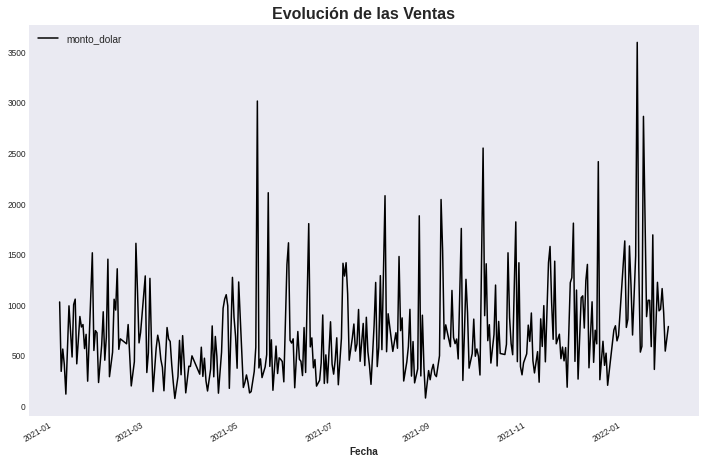

In [10]:
# Evolución de las ventas a lo largo del tiempo
# ==============================================================================
fig, ax = plt.subplots(figsize=(12,8))
ts_ventas.plot(ax=ax)
ax.set_title('Evolución de las Ventas', fontsize=16, weight='bold')
ax.legend()
ax.set_xlabel('Fecha')

### 4.A Descomposición de la Serie<a name="estudio-descomposicion"></a>

A simple vista no se observa una tendencia marcada. Tampoco una estacionalidad.

Sin embargo, en toda serie temporal hay tres componentes importantes: 

**Estacionalidad:** Cuando los datos siguen un patrón que se repite períodicamente y de manera regular

**Tendencia:** Es el comportamiento de los datos a largo plazo. Puede ser creciente o decreciente

**Ruido:**  Son las alteraciones de la serie, pequeñas en su incidencia, y sin una pauta periódica ni tendencial reconocible

Estudiar la descomposición de una serie temporal nos permitirá elegir y optimizar un modelo de predicción.

<AxesSubplot:xlabel='fecha'>

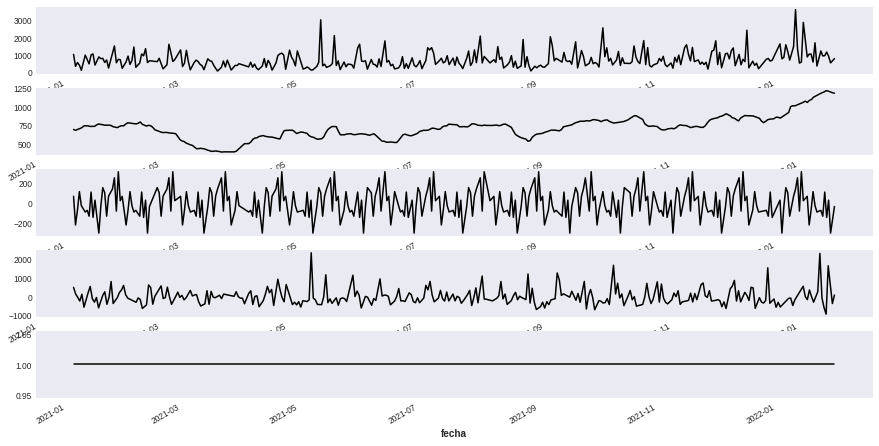

In [11]:
# Descomposición de la serie en Tendencia, Estacionalidad y Ruido
# ==============================================================================
descomposicion = seasonal_decompose(ts_ventas, model='additive', period=22)

fig, (ax1,ax2,ax3, ax4, ax5) = plt.subplots(5,1, figsize=(15,8))
descomposicion.observed.plot(ax=ax1)
descomposicion.trend.plot(ax=ax2)
descomposicion.seasonal.plot(ax=ax3)
descomposicion.resid.plot(ax=ax4)
descomposicion.weights.plot(ax=ax5)

#descomposicion.plot()

We can also see that the residual plot shows zero. This is a good example where the naive, or classical, decomposition was not able to separate the noise that we added from the linear trend.

The naive decomposition method is a simple one, and there are more advanced decompositions available, like Seasonal and Trend decomposition using Loess or STL decomposition.

### 4.B Estudio de la Estacionalidad<a name="estudio-estacionalidad"></a>

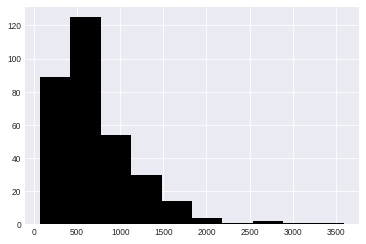

In [12]:
ts_ventas.hist()
plt.show()

fecha
2021-02-02    722.244514
2021-10-19    741.789525
2021-08-10    846.385557
2021-08-31    549.132358
2021-01-25    727.047500
2021-08-17    807.088807
2021-05-07    553.680040
2021-11-08    593.381368
2021-03-05    767.703016
2021-10-26    816.101897
2021-01-06           NaN
2021-02-25    785.030379
Name: monto_dolar, dtype: float64
fecha
2021-06-24    197212.627705
2021-10-05    367795.505333
2022-01-04    386692.378993
2021-10-06    393508.378024
2021-08-25    216670.588074
2021-11-16    176981.173856
2021-05-14    666333.806797
2021-10-21    107846.638017
2021-05-18    615351.887785
2021-05-22    754666.998252
2021-06-29     55673.742466
2021-09-06    226136.302462
Name: monto_dolar, dtype: float64


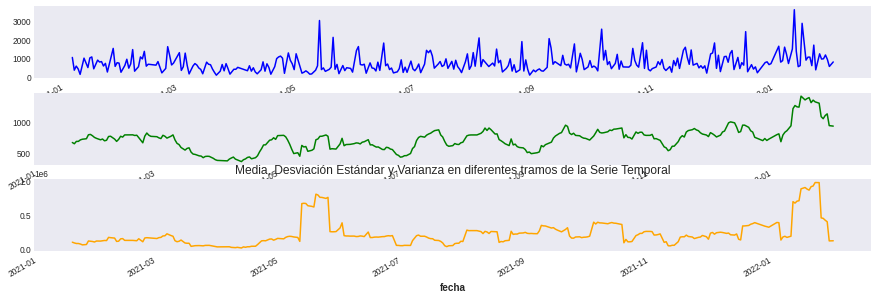

Resultados del test Dickey-Fuller:
Test Estadísticas        -7.109209e+00
p-value                   3.979484e-10
#Lags Utilizados          3.000000e+00
N° de Observaciones       3.170000e+02
Valores críticos (1%)    -3.451148e+00
Valores críticos (5%)    -2.870701e+00
Valores críticos (10%)   -2.571651e+00
dtype: float64


In [13]:
test_estacionalidad(ts_ventas)

Con un **p-value < 0.05** confirmamos la no presencia de una raíz unitaria (rechazamos la hipótesis nula) y por lo tanto la serie **es estacionaria**.

### 4.C Estudio de Autocorrelación<a name="estudio-autocorrelacion"></a>

In [14]:
df_ventas = ts_ventas.reset_index() 
df_ventas

,fecha,monto_dolar
0,2021-01-05,1025.174371
1,2021-01-06,338.556452
2,2021-01-07,559.099981
3,2021-01-08,406.877705
4,2021-01-09,113.560197
...,...,...
316,2022-01-26,953.359244
317,2022-01-27,1157.382664
318,2022-01-28,916.773784
319,2022-01-29,538.966173


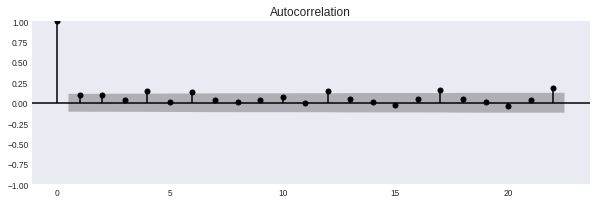

In [15]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))

plot_acf(df_ventas['monto_dolar'], ax=ax, lags=22)
plt.show()

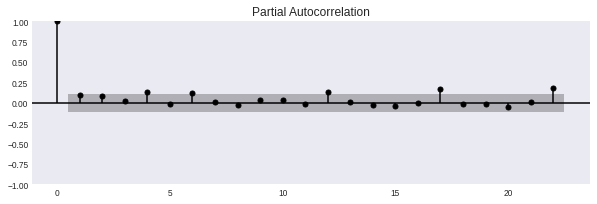

In [16]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(df_ventas['monto_dolar'], ax=ax, lags=22, method='ywm')
plt.show()

Podemos observar en los gráficos ACF y PACF que rápidamente la autocorrelación cae a 0, es decir, que existe muy poca o nula correlación entre los datos. Esto confirma de nuevo que la serie **es estacionaria**.

### 4.E Conclusión<a name="estudio-conclusion"></a>

## 5. Transformación de la Serie Temporal<a name="transformacion-ts"></a>

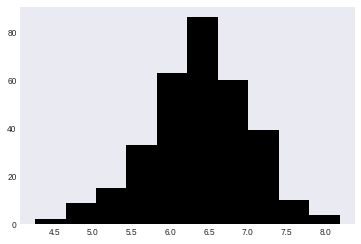

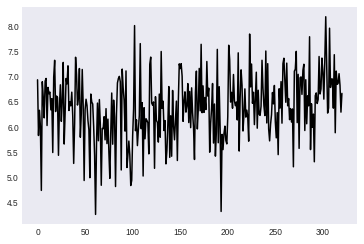

In [17]:
from numpy import log

X = ts_ventas.values
X = log(X)
plt.hist(X)
plt.show()
plt.plot(X)
plt.show()

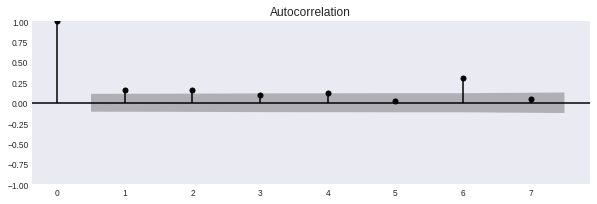

In [18]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(X, ax=ax, lags=7)
plt.show()

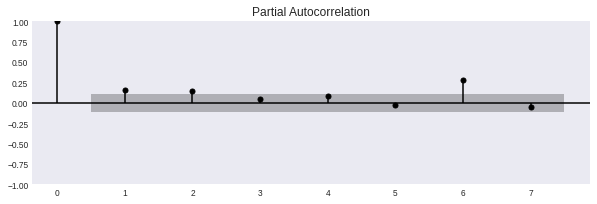

In [19]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(X, ax=ax, lags=7, method='ywm')
plt.show()

## 6. Modelado<a name="modelado"></a>

### 6.A Partición del DataSet<a name="particion-ds"></a>

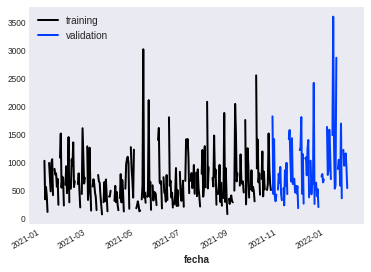

In [20]:
## Importing Libraries
#import sys
#import time
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from datetime import datetime
#from functools import reduce

## Load the pre-loaded Dataset
series = TimeSeries.from_dataframe(df_ventas, time_col='fecha', fill_missing_dates=True, freq='d') 

## Split train and test data
train, val = series.split_before(0.75)
train.plot(label='training')
val.plot(label='validation')
plt.legend()

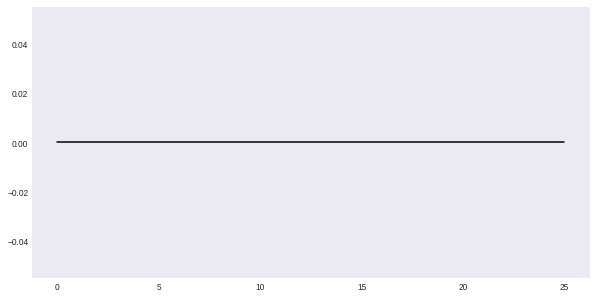

In [21]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=3, alpha=0.05)

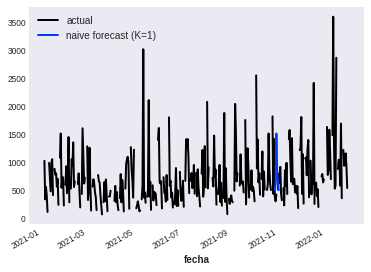

In [22]:
naive_model = NaiveSeasonal(K=10)
naive_model.fit(train)
naive_forecast = naive_model.predict(10)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

model Naive seasonal model, with K=1 obtains MAPE: nan%
model Prophet obtains MAPE: 45.33%
model ARIMA(12, 1, 0) obtains MAPE: 52.55%
model Theta(2) obtains MAPE: nan%
The MAPE is: nan, with theta = 1e-08.


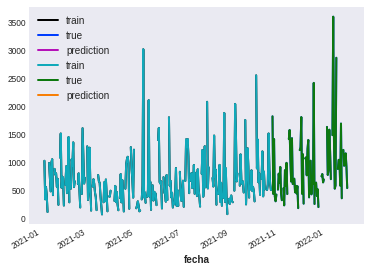

In [23]:
## Fitting multiple models and checking the MAPE
def eval_model(model):
    global forecast
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(NaiveSeasonal())
#eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(ARIMA())
eval_model(Theta())

## Visualizing theta foreacsting result
train.plot(label='train')
val.plot(label='true')
forecast.plot(label='prediction')
plt.legend();

## Tuning the theta parameter to see if MAPE reduces
## Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 10)

best_mape = float('inf')
best_theta = 0.00000001

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta
        
## Fitting and predicting again using best theta value
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

## Visualize 
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();

## 7. Glosario<a name="glosario"></a>

**Autocorrelación:** Es un término estadístico que se utiliza para describir la presencia o ausencia de correlación en los datos de las series temporales, indicando, si las observaciones pasadas influyen en las actuales. Es cuando los valores que toma una variable en el tiempo no son independientes entre sí, sino que un valor determinado depende de los valores anteriores.

**Estacionalidad:** Cuando los datos siguen un patrón que se repite períodicamente y de manera regular.

**Hipótesis alternativa:** Es la hipótesis que pensamos es cierta en una observación. Es lo que el investigador realmente piensa que es la causa de un fenómeno.

**Hipótesis nula:** Es la hipótesis contraria a la hipótesis alternativa. Es la hipótesis que el investigador trata de refutar, rechazar o anular. La hipótesis nula generalmente incluye un no en su enunciado.

**MAPE - Error Medio de Porcentaje Absoluto:** 

**Proceso estocástico:** Un proceso estocástico es aquel que no se puede predecir, se mueve al azar, es aleatorio. En el caso de las series temporales, se trata de fenómenos que medimos a intervalos regulares de tiempo pero cuyos valores es imposible predecir en un momento preciso dado, ya que son completamente aleatorios. Existen los **procesos estocásticos no estacionarios** que son imposibles de predecir. Pero también existen los **procesos estocásticos estacionarios** que tienen una serie de características que los hacen, en cierta manera, predecibles.

**Prueba de Dickey-Fuller:** Es una prueba que busca determinar la existencia o no de raíces unitarias en una serie de tiempo. Nos permite saber si hay presencia significativa de tendencia en las series temporales de las variables mediante un contraste de hipótesis. La hipótesis nula de esta prueba es que existe una raíz unitaria en la serie y por lo tanto no es estacionaria.

**Raíz unitaria:** Una raíz unitaria es una tendencia estocástica en la serie temporal. Algunas veces se le llama “paseo aleatorio con deriva”. Por tanto, si la serie tiene una raíz unitaria, ésta presenta un patrón sistemático que es impredecible.

**Ruido:**  Son las alteraciones de la serie, pequeñas en su incidencia, y sin una pauta periódica ni tendencial reconocible. En el ruido blanco no existe ninguna relación de correlación entre los valores de la serie. Es una secuencia de variables aleatorias no correlacionadas pero con una media y varianza constantes.

**Serie estacionaria:** Una serie temporal es estacionaria cuando la media y la variabilidad se mantienen constantes a lo largo del tiempo, es decir, sus valores no son función del tiempo; y además, no presenta tendencia. Graáficamente significa que los valores oscilan alrededor de una media constante y la variabilidad también se matiene constante a lo largo del tiempo. La mayoría de modelos que describen e intentan predecir el comportamiento de las series temporales funcionan bajo el supuesto de que la serie es estacionaria.

**Serie temporal:** Una serie temporal es una secuencia de valores medida regularmente a lo largo del tiempo.
Es una serie de datos consecutivos en un espacio de tiempo. Con el análisis de series temporales buscamos comprender el pasado y “predecir” el futuro.

**Tendencia:** Es el comportamiento de los datos a largo plazo. Puede ser creciente o decreciente.

